In [1]:
from scipy.io import loadmat
import numpy as np
import seaborn as sns
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.metrics import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras import backend as K
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from data.preprocess import *
from evaluation.evaluate import *
from evaluation.benchmark import *
data = preprocess(path='../data/raw/CD_PD.mat')

In [2]:
K.clear_session()

## Predict label PD diagnosis

In [3]:
def get_age_gender_data(data, mode='diagnosis'):
    #get shuffled data
    data_train, data_test = split_by_patient(data)
    
    #label PD
    y_test = data_test[mode].astype(np.float32)
    y_train = data_train[mode].astype(np.float32)
    
    age_train = data_train['age'].astype(np.float32)
    age_train = age_train.reshape(1, *age_train.shape).T
    gender_train = data_train['gender'].astype(np.float32)
    gender_train = gender_train.reshape(1, *gender_train.shape).T

    age_test = data_test['age'].astype(np.float32)
    age_test = age_test.reshape(1, *age_test.shape).T
    gender_test = data_test['gender'].astype(np.float32)
    gender_test = gender_test.reshape(1, *gender_test.shape).T
    
    #x
    x_train = np.concatenate((age_train,gender_train),axis=1)
    x_test = np.concatenate((age_test, gender_test), axis=1)
    
    return x_test, x_train, y_test, y_train

In [4]:
x_test, x_train, y_test, y_train = get_age_gender_data(data)
x_train.shape, x_test.shape, y_test.shape, y_train.shape

((156, 2), (40, 2), (40,), (156,))

# Dense1 (age + gender)

In [5]:
def get_nn_model():
    #optimizer
    adam = Adam(lr=1e-4)
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(2,)))
    model.add(BatchNormalization())
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=adam)
    model.build()
    return model
_ = get_nn_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               300       
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

# Performance Evaluation

We will run the model training & inference k times and evaluate the average performance 

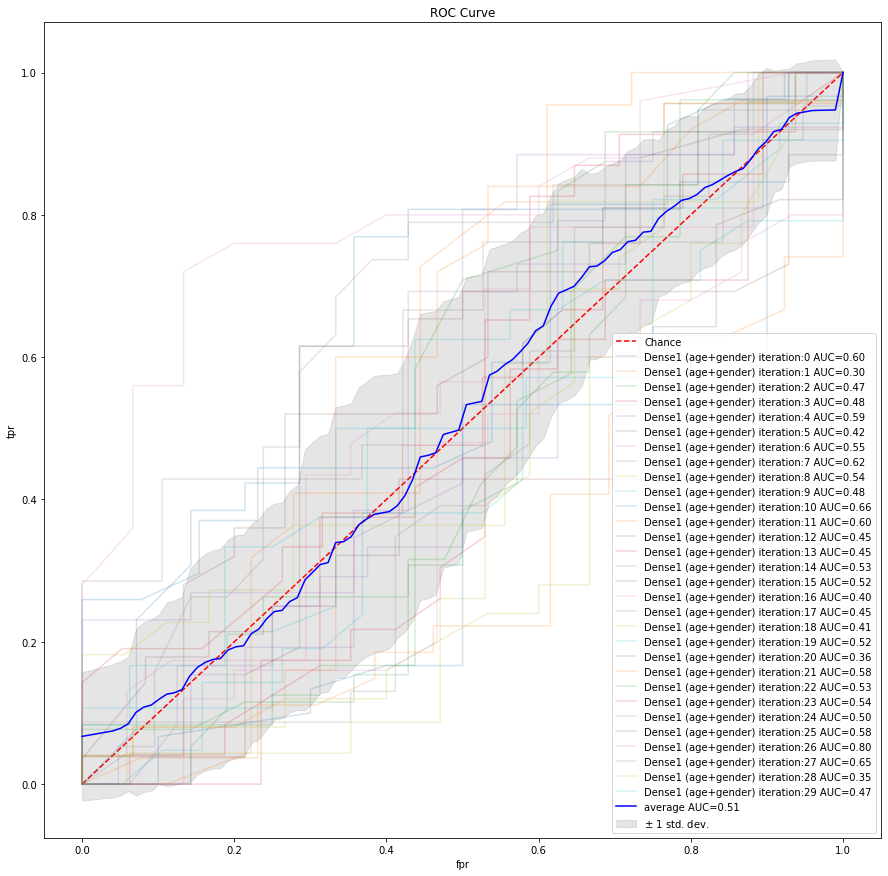

In [6]:
models1, plots1, results1 = run_benchmark(get_age_gender_data, get_nn_model, data, k=30, epochs=100, model_name='Dense1 (age+gender)')

# Dense 2 (age + gender + Ed + Side + TMSE)

In [7]:
def get_nn2_model():
    #optimizer
    adam = Adam(lr=1e-4)
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(5,)))
    model.add(BatchNormalization())
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=adam)
    model.build()
    return model
_ = get_nn_model().summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_124 (Dense)            (None, 100)               300       
_________________________________________________________________
batch_normalization_93 (Batc (None, 100)               400       
_________________________________________________________________
dense_125 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_94 (Batc (None, 100)               400       
_________________________________________________________________
dense_126 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_95 (Batc (None, 100)               400       
_________________________________________________________________
dense_127 (Dense)            (None, 1)               

In [8]:
def get_all_non_temporal_data(data, mode='diagnosis'):
    #get shuffled data
    data_train, data_test = split_by_patient(data)
    
    #label PD
    y_test = data_test[mode].astype(np.float32)
    y_train = data_train[mode].astype(np.float32)
    
    features = ['age', 'gender', 'ed', 'side', 'TMSE']
    features_train, features_test = [], []
    for f in features:
        feature_train = data_train[f].astype(np.float32)
        feature_train = feature_train.reshape(1, *data_train.shape).T
        feature_test = data_test[f].astype(np.float32)
        feature_test = feature_test.reshape(1, *data_test.shape).T
        
        features_train.append(feature_train)
        features_test.append(feature_test)
    #x
    x_train = np.concatenate(features_train,axis=1)
    x_test = np.concatenate(features_test , axis=1)
    
    return x_test, x_train, y_test, y_train

#sanity check
x_test, x_train, y_test, y_train = get_all_non_temporal_data(data)
x_test[:3]

array([[50.,  1.,  4.,  1., 30.],
       [78.,  0.,  2.,  1., 29.],
       [56.,  0.,  4.,  1., 29.]], dtype=float32)

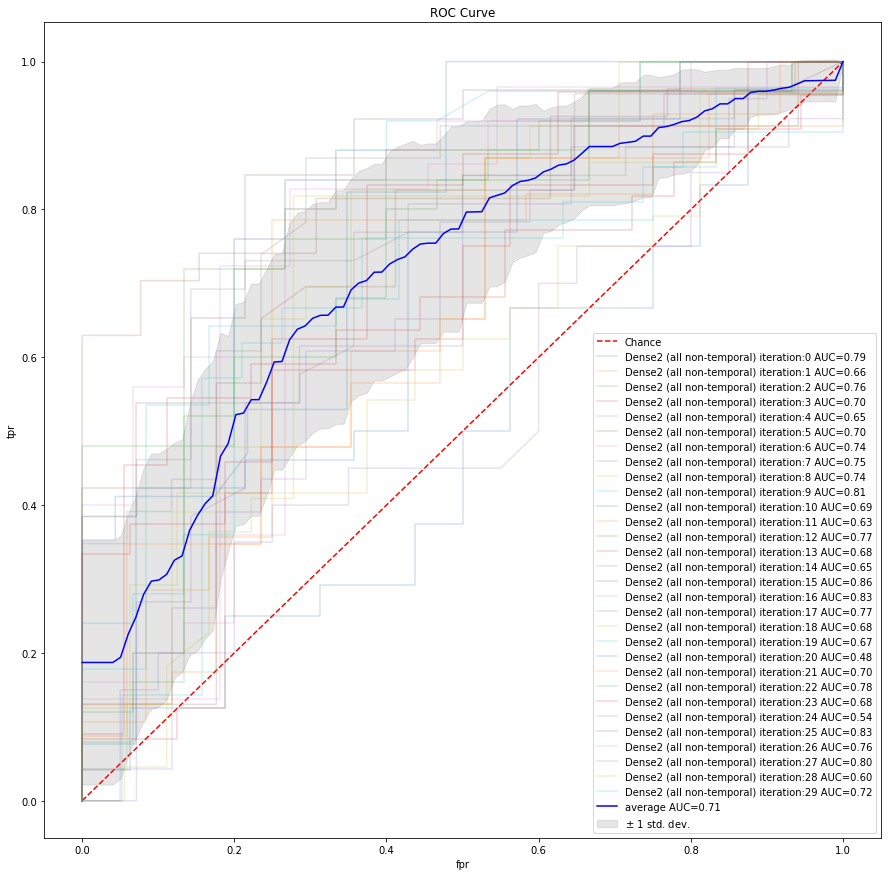

In [9]:
models2, plots2, results2 = run_benchmark(get_all_non_temporal_data, get_nn2_model, data, k=30, epochs=100, \
                       model_name='Dense2 (all non-temporal)', verbose=0)


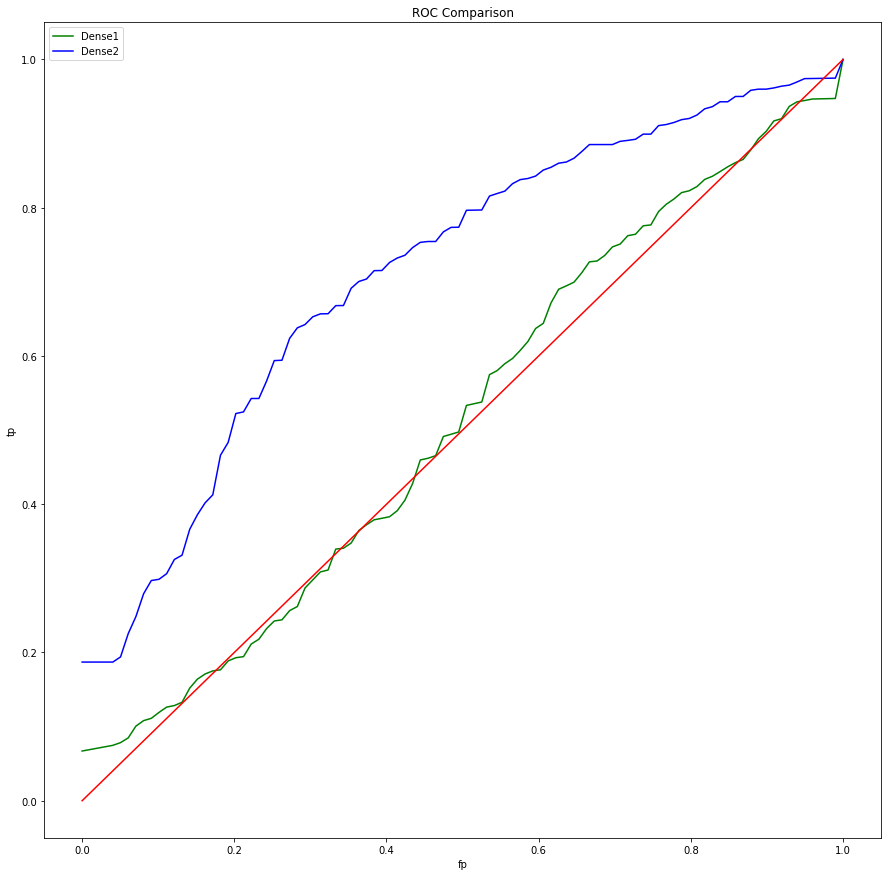

In [13]:
plt.figure(figsize=(15,15))
plt.plot(np.linspace(0,1,100), plots1['mean_tp'],label='Dense1', color='green')
plt.plot(np.linspace(0,1,100), plots2['mean_tp'],label='Dense2', color='blue')
plt.title('ROC Comparison')
plt.xlabel('fp')
plt.ylabel('tp')
plt.legend()
plt.plot([0, 1], [0, 1], color='red', label='Chance')